In this notebook NLP and EDA will be performed on subreddits dataset.

In [3]:
import requests
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

In [4]:
df = pd.read_csv('data/subreddits.csv')

### Converting python/R to binary labels:

In [5]:
# Create label column for Python and Rlanguage subreddits
df['subreddit'] = df['subreddit'].map({'breakingbad': 0, 'betterCallSaul': 1})

df.drop(columns = 'Unnamed: 0', inplace= True)
df.head()

,subreddit,selftext,title
0,1,So i noticed some simularities between the Wer...,Of Mice and Men (Season 4 spoilers)
1,1,NaN,"Tv/Movie talk: Better call saul, last of us, a..."
2,1,Been watching like crazy the last month. We ju...,How to watch season 6?
3,1,.,Best episode in season 6?
4,1,[removed],Which was the most gruesome death in the BRBA ...


In [6]:
# Rename Column name
df = df.rename(columns={'selftext': 'post'})
df.isna().sum()

subreddit       0
post         2496
title           0
dtype: int64

In [7]:
# Function to count words in each post:
def word_count(post):
    word_count = 0
    is_in_word = False
    for char in post:
        if char in ' \t\n.!,:;/?\\()"':
            is_in_word = False
        else:
            if not is_in_word:
                word_count += 1
                is_in_word = True

    return (word_count)

In [8]:
# Adding two columns showing number of words in each text
df['title_length'] = [word_count(comment) for comment in df['title']]
df.shape

(4993, 4)

In [9]:
df.head()

,subreddit,post,title,title_length
0,1,So i noticed some simularities between the Wer...,Of Mice and Men (Season 4 spoilers),7
1,1,NaN,"Tv/Movie talk: Better call saul, last of us, a...",20
2,1,Been watching like crazy the last month. We ju...,How to watch season 6?,5
3,1,.,Best episode in season 6?,5
4,1,[removed],Which was the most gruesome death in the BRBA ...,10


# NPL

In [10]:
X = df['title']
y = df['subreddit']

In [11]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

# Preprocessing

#### Countvectorizer

In [12]:
# Instantiate with stop words and n-grams:
cvec = CountVectorizer(stop_words = 'english', 
                       ngram_range = (1,2), 
                       max_features=100, 
                       min_df=2, 
                       max_df=.98)

In [13]:
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [14]:
X_train.shape

(3744, 100)

In [15]:
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


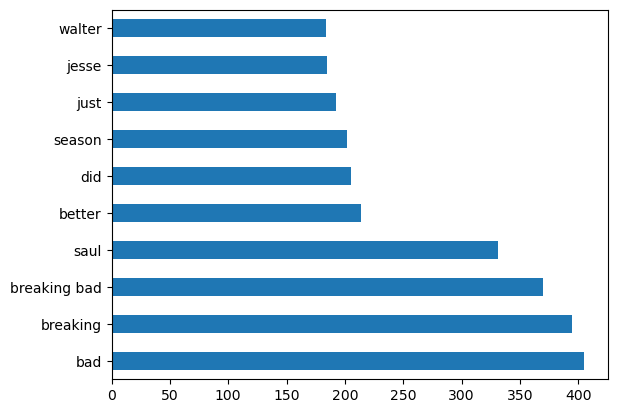

In [16]:
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

#### Baseline Accuracy

In [17]:
y_test.value_counts(normalize = True)

0    0.5004
1    0.4996
Name: subreddit, dtype: float64

In [18]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [19]:
# Try max_depth=None vs max_depth=1
tree = DecisionTreeClassifier(max_depth=1, random_state=111)
ada = AdaBoostClassifier(tree, n_estimators=100, learning_rate=1, algorithm='SAMME.R')

In [20]:
#gb = GradientBoostingClassifier()

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', 
                       ngram_range = (1,2), max_features=300, 
                      min_df=2, max_df=.98)),
    ('ada', AdaBoostClassifier(tree, n_estimators=100, 
                               learning_rate=1, algorithm='SAMME.R'))
])

In [21]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(max_df=0.98, max_features=300, min_df=2, ngram_range=(1, 2),
                   stop_words='english')),
  ('ada',
   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                            random_state=111),
                      learning_rate=1, n_estimators=100))],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.98, max_features=300, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                          random_state=111),
                    learning_rate=1, n_estimators=100),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.98,
 'cvec__max_features': 300,
 'cvec__min_df': 

In [22]:
pipe_params = {
    'cvec__max_features': [200, 300],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
}

In [23]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [24]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.98,
                                                        max_features=300,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                                 random_state=111),
                                                           learning_rate=1,
                                                           n_estimators=100))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [200, 300],
                         

In [25]:
# Best Params
gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 200,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [26]:
# Score model on training set.
gs.score(X_train, y_train)

0.7483974358974359

In [27]:
# Score model on testing set.
gs.score(X_test, y_test)

0.6981585268214572

In [62]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


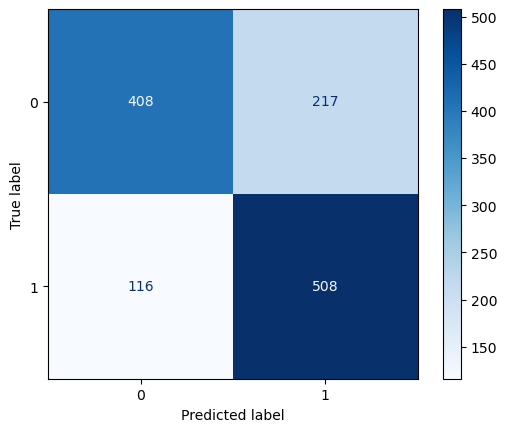

In [63]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [64]:
# Calculate the specificity
spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.6528


## TfidfVectorizer

In [66]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)
tvec = TfidfVectorizer()
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english', 
                       ngram_range = (1,2), max_features=300, 
                      min_df=2, max_df=.98)),
    ('rf', RandomForestClassifier())
])
pipe_tvec.get_params()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(max_df=0.98, max_features=300, min_df=2, ngram_range=(1, 2),
                   stop_words='english')),
  ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(max_df=0.98, max_features=300, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 0.98,
 'tvec__max_features': 300,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': 'english',
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alp

In [67]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}
gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv = 5)
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_df=0.98,
                                                        max_features=300,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [68]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9620726495726496

In [69]:
gs_tvec.score(X_test, y_test)

0.7502001601281025

In [70]:
# Best params?
gs_tvec.best_params_

{'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [71]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.7728


/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


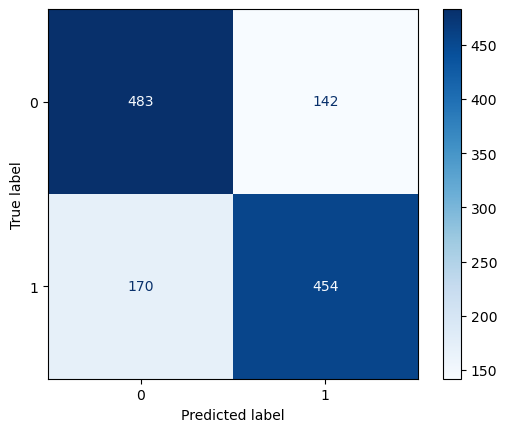

In [72]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap = 'Blues');